## Lab 8 z Podstaw Uczenia Maszynowego - Siec Neuronowa
### Autor: Dominik Pabiniak
### Nr indeksu: 254397

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def sensitivity(m_p):
    return round((m_p[0][0]/(m_p[0][0] + m_p[0][1])), 4)
def specificity(m_p):
    return round((m_p[1][1]/(m_p[1][0] + m_p[1][1])), 4)

def plot_class(X_syn_test, y_syn_test, model, method):
        X_pred_0 = X_syn_test[y_syn_test == 0]
        X_pred_1 = X_syn_test[y_syn_test == 1]
        x_min, x_max = X_syn_test[:, 0].min() - 0.2, X_syn_test[:, 0].max() + 0.2
        y_min, y_max = X_syn_test[:, 1].min() - 0.2, X_syn_test[:, 1].max() + 0.2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.2)
        plt.scatter(X_pred_0[:, 0], X_pred_0[:, 1], marker='.', label='Klasa 1')
        plt.scatter(X_pred_1[:, 0], X_pred_1[:, 1], marker='.', label='Klasa 2')
        plt.title(f'Powierzchnia decyzyjna {method}')
        plt.xlabel('Cecha 1')
        plt.ylabel('Cecha 2')
        plt.legend()

def pred_info(y_test, y_pred, name_of_method):
    accuracy = accuracy_score(y_test, y_pred)
    c_matrix = confusion_matrix(y_test, y_pred)
    print(f'\n{name_of_method}:')
    print(f'Macierz pomylek: \n{c_matrix}')
    print(f'Dokladnosc: {accuracy}\nCzulosc: {sensitivity(c_matrix)}\nSwoistosc: {specificity(c_matrix)}')

In [2]:
class MSE:
    def loss(self, y_pred, t):
        np.sum((t-y_pred)**2)

    def grad(self, y_pred, t):
        return 2 * (y_pred - t)

In [3]:
class Linear:
    def __init__(self, input_size, output_size):
        self.params = {}
        self.grads = {}
        self.params['w'] = np.random.randn(input_size, output_size)
        self.params['b'] = np.random.randn(output_size)

    def forward(self, inputs):
        self.inputs = inputs
        return inputs @ self.params['w'] + self.params['b']
    
    def backward(self, grad):
        self.grads['b'] = np.sum(grad, axis=0)
        self.grads['w'] = self.inputs.T @ grad
        return grad @ self.params['w'].T
    

class Activation:
    def __init__(self, func, deriv):
        self.params = {}
        self.grads = {}
        self.func = func
        self.deriv = deriv

    def forward(self, s):
        self.inputs = s
        return self.func(s)
    
    def backward(self, grad):
        return self.deriv @ grad
    
def ReLu_actv(X):
        return np.maximum(0, X)
def ReLu_deriv(X):
    return np.where(X >= 0, 1, 0)

def logistic_actv(X):
        return 1 / (1 + np.exp(-X))
def logistic_deriv(X):
    y = logistic_actv(X)
    return y * (1-y)

class ReLu(Activation):
     def __init__(self):
          super().__init__(ReLu_actv, ReLu_deriv)

class Logistic(Activation):
     def __init__(self):
          super().__init__(logistic_actv, logistic_deriv)

In [4]:
class MNeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.y_pred = []

    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def params_and_grads(self):
        for layer in self.layers:
            for name, param in layer.params.items():
                grad = layer.grads[name]
                yield param, grad

    def predict(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        for predict in inputs:
            self.y_pred.append(np.argmax(predict))
        return np.array(self.y_pred)

In [5]:
class SGD:
    def __init__(self, eta = 0.01):
        self.eta = eta

    def step(self, net):
        for param, grad in net.params_and_grads():
            param -= self.eta * grad

In [6]:
from typing import NamedTuple


Batch = NamedTuple("Batch", [("inputs", np.array), ("targets", np.array)])


class BatchIterator:
    def __init__(self, batch_size = 32, shuffle = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs, targets):
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

In [7]:
def train(net, inputs, targets, num_epochs=5000, iterator = BatchIterator(), loss=MSE(), optimizer=SGD()):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in iterator(inputs, targets):
            predicted = net.forward(batch.inputs)
            epoch_loss += loss.loss(predicted, batch.targets)
            grad = loss.grad(predicted, batch.targets)
            net.backward(grad)
            optimizer.step(net)

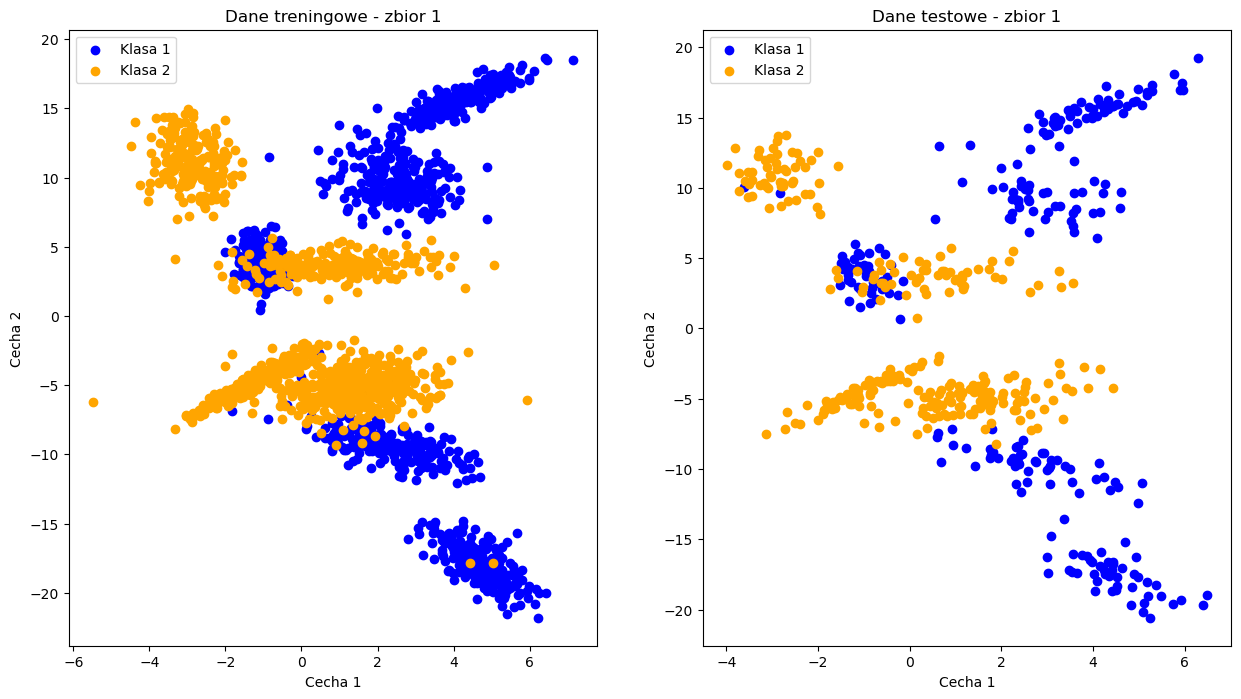

In [8]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# Dane wejsciowe
X, t = make_classification(n_samples=2597, n_features=4, n_informative=4, n_repeated=0, n_clusters_per_class=5, random_state=254397, hypercube=False, n_redundant=0, class_sep=20)
X = X[:,:2]
#Podzial na podzbiory
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, t, test_size=0.2, random_state=254397)

# Podzial zbiorow na klasy w celu ich wyswietlenia
klasa_0_train = X_train_4[(y_train_4 == 0)]
klasa_1_train = X_train_4[(y_train_4 == 1)]
klasa_0_test = X_test_4[(y_test_4 == 0)]
klasa_1_test = X_test_4[(y_test_4 == 1)]

# Wyswietlenie danych
_, axs = plt.subplots(1, 2, figsize=(15, 8))
ax = axs[0]
ax.scatter(klasa_0_train[:,0], klasa_0_train[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_train[:,0], klasa_1_train[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane treningowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

ax = axs[1]
ax.scatter(klasa_0_test[:,0], klasa_0_test[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_test[:,0], klasa_1_test[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane testowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

In [9]:
nn = MNeuralNetwork([
    Linear(input_size=2, output_size=2),
    Logistic(),
    Linear(input_size=2, output_size=2),
])

y_train_4 = y_train_4.reshape(-1,1)
print(y_train_4)
train(nn, X_train_4, y_train_4)
predicted = nn.forward(X_test_4)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


TypeError: unsupported operand type(s) for +=: 'float' and 'NoneType'